Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec  8 15:03:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/PGD_IIITB_Student/Melanoma Classification/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/PGD_IIITB_Student/Melanoma Classification/Test')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,validation_split=0.2,subset="training",seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,validation_split=0.2,subset="validation",seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [11]:
print(class_names[1])

basal cell carcinoma


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [49]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [63]:
### Your code goes here
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [15]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [64]:
# View the summary of all layers
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 45, 45, 64)       

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 11s 48ms/step - loss: 1.9763 - accuracy: 0.2494 - val_loss: 1.7302 - val_accuracy: 0.3490
Epoch 2/20
56/56 [==============================] - 1s 14ms/step - loss: 1.6079 - accuracy: 0.4096 - val_loss: 1.5123 - val_accuracy: 0.4474
Epoch 3/20
56/56 [==============================] - 1s 14ms/step - loss: 1.4291 - accuracy: 0.4989 - val_loss: 1.6418 - val_accuracy: 0.4318
Epoch 4/20
56/56 [==============================] - 1s 14ms/step - loss: 1.3934 - accuracy: 0.5123 - val_loss: 1.3913 - val_accuracy: 0.5302
Epoch 5/20
56/56 [==============================] - 1s 14ms/step - loss: 1.2184 - accuracy: 0.5709 - val_loss: 1.4397 - val_accuracy: 0.5414
Epoch 6/20
56/56 [==============================] - 1s 14ms/step - loss: 1.1728 - accuracy: 0.5932 - val_loss: 1.3875 - val_accuracy: 0.5727
Epoch 7/20
56/56 [==============================] - 1s 14ms/step - loss: 1.0661 - accuracy: 0.6177 - val_loss: 1.4418 - val_accuracy: 0.5034
Epoch 8/20
5

### Visualizing training results

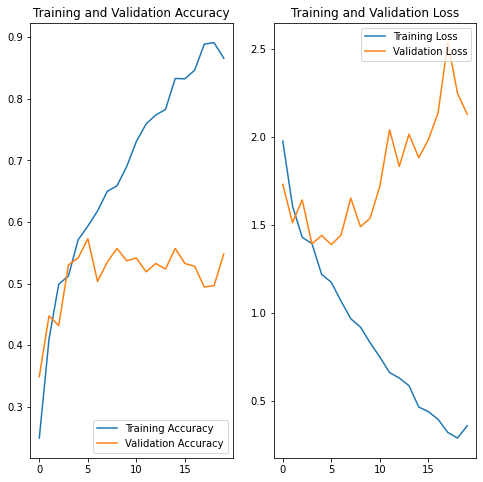

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

The model is heavily overfitting. The train loss is quite small with 0.35 and val loss is around 2.3. The accuracy is also extremely poor for val dataset with a huge overfitting.

In [50]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.2),
    layers.RandomFlip("vertical")
  ])

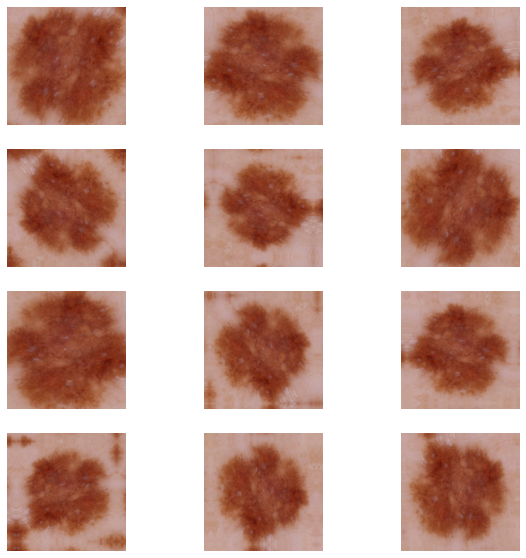

In [54]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(12):
        augment_img = data_augmentation(images)
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(augment_img[0].numpy().astype("uint8"))
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [21]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compiling the model

In [22]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Training the model

In [24]:
## Your code goes here, note: train your model for 20 epochs
## your training code

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 19ms/step - loss: 2.0564 - accuracy: 0.2483 - val_loss: 1.9017 - val_accuracy: 0.2662
Epoch 2/20
56/56 [==============================] - 1s 16ms/step - loss: 1.6566 - accuracy: 0.3867 - val_loss: 1.5567 - val_accuracy: 0.4228
Epoch 3/20
56/56 [==============================] - 1s 17ms/step - loss: 1.5982 - accuracy: 0.4381 - val_loss: 1.6255 - val_accuracy: 0.4161
Epoch 4/20
56/56 [==============================] - 1s 16ms/step - loss: 1.4245 - accuracy: 0.4961 - val_loss: 1.5133 - val_accuracy: 0.5078
Epoch 5/20
56/56 [==============================] - 1s 17ms/step - loss: 1.3698 - accuracy: 0.5123 - val_loss: 1.4731 - val_accuracy: 0.5235
Epoch 6/20
56/56 [==============================] - 1s 16ms/step - loss: 1.3143 - accuracy: 0.5446 - val_loss: 1.4080 - val_accuracy: 0.5190
Epoch 7/20
56/56 [==============================] - 1s 16ms/step - loss: 1.3192 - accuracy: 0.5363 - val_loss: 1.3857 - val_accuracy: 0.5168
Epoch 8/20
56

### Visualizing the results

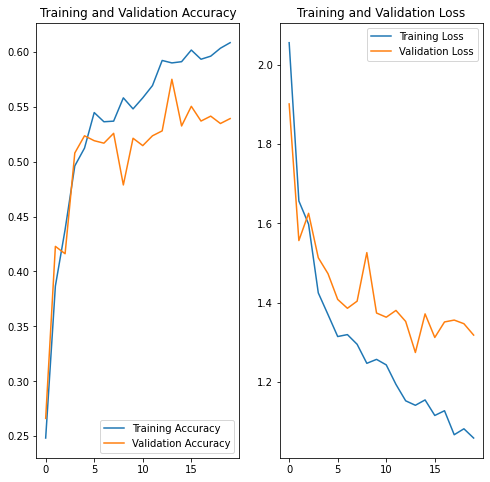

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

The overfitting has decreased by quite much but the accuracy didnt improve much beyond 0.53.

There is still a lot of scope to improve the model still. The biggest problem that we are facing is the data imbalance. Augmentation has improved the performance so we can augment all the classes by adding 500 more images to each class.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [11]:
d1 = {}
for i in range(9):
    list1 = os.listdir('/content/drive/MyDrive/PGD_IIITB_Student/Melanoma Classification/Train/'+class_names[i])
    number_files = len(list1)
    d1[class_names[i]] = number_files
d1

{'actinic keratosis': 114,
 'basal cell carcinoma': 376,
 'dermatofibroma': 95,
 'melanoma': 438,
 'nevus': 357,
 'pigmented benign keratosis': 462,
 'seborrheic keratosis': 77,
 'squamous cell carcinoma': 181,
 'vascular lesion': 139}

#### **Todo:** Write your findings here: 

##### - Seborrheic keratosis has the least number of samples with just 77 datapoints.

##### - Pigmented benign keratosis has the maximum number of data points with 462. Thus it will dominate the classification results if data remains unbalanced.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [12]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [13]:
path_to_training_dataset="/content/drive/MyDrive/PGD_IIITB_Student/Melanoma Classification/Train/"
import Augmentor
for i in class_names:
    print(i)
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

actinic keratosis
Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/PGD_IIITB_Student/Melanoma Classification/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F05B00852D0>: 100%|██████████| 500/500 [00:09<00:00, 54.36 Samples/s]


basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/PGD_IIITB_Student/Melanoma Classification/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F05B003A1D0>: 100%|██████████| 500/500 [00:09<00:00, 51.93 Samples/s] 


dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/PGD_IIITB_Student/Melanoma Classification/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F05B00D06D0>: 100%|██████████| 500/500 [00:09<00:00, 54.84 Samples/s]


melanoma
Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/PGD_IIITB_Student/Melanoma Classification/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F05B01B5690>: 100%|██████████| 500/500 [00:40<00:00, 12.26 Samples/s]


nevus
Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/PGD_IIITB_Student/Melanoma Classification/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1504x1129 at 0x7F05B01B7990>: 100%|██████████| 500/500 [00:39<00:00, 12.81 Samples/s]


pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/PGD_IIITB_Student/Melanoma Classification/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F05B01563D0>: 100%|██████████| 500/500 [00:09<00:00, 50.67 Samples/s]


seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/PGD_IIITB_Student/Melanoma Classification/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F05B003A990>: 100%|██████████| 500/500 [00:21<00:00, 23.69 Samples/s]


squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/PGD_IIITB_Student/Melanoma Classification/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F05B0053210>: 100%|██████████| 500/500 [00:08<00:00, 56.25 Samples/s]


vascular lesion
Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/PGD_IIITB_Student/Melanoma Classification/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F05B003A390>: 100%|██████████| 500/500 [00:09<00:00, 52.94 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [14]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [15]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list

In [16]:
len(path_list)

4500

In [17]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new

In [18]:
len(lesion_list_new)

4500

In [19]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [20]:
len(dataframe_dict_new)

4500

In [21]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [22]:
df2['Label'].value_counts()

pigmented benign keratosis    500
dermatofibroma                500
seborrheic keratosis          500
melanoma                      500
vascular lesion               500
basal cell carcinoma          500
nevus                         500
actinic keratosis             500
squamous cell carcinoma       500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [24]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [25]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [26]:
import shutil
import os

src_dir = "/content/drive/MyDrive/PGD_IIITB_Student/Melanoma Classification/Train/actinic keratosis/output"
dst_dir = "/content/drive/MyDrive/PGD_IIITB_Student/Melanoma Classification/Train/actinic keratosis"
for jpgfile in glob(os.path.join(src_dir, '*.jpg')):
    shutil.copy(jpgfile, dst_dir)

In [27]:
src_dir1 = "/content/drive/MyDrive/PGD_IIITB_Student/Melanoma Classification/Train/basal cell carcinoma/output"
dst_dir1 = "/content/drive/MyDrive/PGD_IIITB_Student/Melanoma Classification/Train/basal cell carcinoma"
for jpgfile in glob(os.path.join(src_dir1, '*.jpg')):
    shutil.copy(jpgfile, dst_dir1)

In [28]:
src_dir1 = "/content/drive/MyDrive/PGD_IIITB_Student/Melanoma Classification/Train/dermatofibroma/output"
dst_dir1 = "/content/drive/MyDrive/PGD_IIITB_Student/Melanoma Classification/Train/dermatofibroma"
for jpgfile in glob(os.path.join(src_dir1, '*.jpg')):
    shutil.copy(jpgfile, dst_dir1)

In [29]:
src_dir1 = "/content/drive/MyDrive/PGD_IIITB_Student/Melanoma Classification/Train/melanoma/output"
dst_dir1 = "/content/drive/MyDrive/PGD_IIITB_Student/Melanoma Classification/Train/melanoma"
for jpgfile in glob(os.path.join(src_dir1, '*.jpg')):
    shutil.copy(jpgfile, dst_dir1)

In [30]:
src_dir1 = "/content/drive/MyDrive/PGD_IIITB_Student/Melanoma Classification/Train/nevus/output"
dst_dir1 = "/content/drive/MyDrive/PGD_IIITB_Student/Melanoma Classification/Train/nevus"
for jpgfile in glob(os.path.join(src_dir1, '*.jpg')):
    shutil.copy(jpgfile, dst_dir1)

In [31]:
src_dir1 = "/content/drive/MyDrive/PGD_IIITB_Student/Melanoma Classification/Train/pigmented benign keratosis/output"
dst_dir1 = "/content/drive/MyDrive/PGD_IIITB_Student/Melanoma Classification/Train/pigmented benign keratosis"
for jpgfile in glob(os.path.join(src_dir1, '*.jpg')):
    shutil.copy(jpgfile, dst_dir1)

In [32]:
src_dir1 = "/content/drive/MyDrive/PGD_IIITB_Student/Melanoma Classification/Train/seborrheic keratosis/output"
dst_dir1 = "/content/drive/MyDrive/PGD_IIITB_Student/Melanoma Classification/Train/seborrheic keratosis"
for jpgfile in glob(os.path.join(src_dir1, '*.jpg')):
    shutil.copy(jpgfile, dst_dir1)

In [33]:
src_dir1 = "/content/drive/MyDrive/PGD_IIITB_Student/Melanoma Classification/Train/squamous cell carcinoma/output"
dst_dir1 = "/content/drive/MyDrive/PGD_IIITB_Student/Melanoma Classification/Train/squamous cell carcinoma"
for jpgfile in glob(os.path.join(src_dir1, '*.jpg')):
    shutil.copy(jpgfile, dst_dir1)

In [34]:
src_dir1 = "/content/drive/MyDrive/PGD_IIITB_Student/Melanoma Classification/Train/vascular lesion/output"
dst_dir1 = "/content/drive/MyDrive/PGD_IIITB_Student/Melanoma Classification/Train/vascular lesion"
for jpgfile in glob(os.path.join(src_dir1, '*.jpg')):
    shutil.copy(jpgfile, dst_dir1)

In [35]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

6739


In [36]:
d1_new = {}
for i in range(9):
    list1 = os.listdir('/content/drive/MyDrive/PGD_IIITB_Student/Melanoma Classification/Train/'+class_names[i])
    number_files = len(list1)
    d1_new[class_names[i]] = number_files
d1_new

{'actinic keratosis': 615,
 'basal cell carcinoma': 877,
 'dermatofibroma': 596,
 'melanoma': 939,
 'nevus': 858,
 'pigmented benign keratosis': 963,
 'seborrheic keratosis': 578,
 'squamous cell carcinoma': 682,
 'vascular lesion': 640}

We can see that the imbalance of the dataset is greatly reduced.

In [37]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [38]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [41]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [59]:
## your code goes here
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [56]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [60]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 45, 45, 32)       

#### **Todo:**  Train your model

In [45]:
epochs = 50
## Your code goes here, use 50 epochs.
# your model fit code
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
281/281 [==============================] - 69s 50ms/step - loss: 1.8560 - accuracy: 0.2879 - val_loss: 1.5377 - val_accuracy: 0.4201
Epoch 2/50
281/281 [==============================] - 4s 13ms/step - loss: 1.3407 - accuracy: 0.4969 - val_loss: 1.1993 - val_accuracy: 0.5696
Epoch 3/50
281/281 [==============================] - 4s 13ms/step - loss: 1.0782 - accuracy: 0.6019 - val_loss: 1.0151 - val_accuracy: 0.6377
Epoch 4/50
281/281 [==============================] - 4s 13ms/step - loss: 0.8583 - accuracy: 0.6935 - val_loss: 0.9831 - val_accuracy: 0.6502
Epoch 5/50
281/281 [==============================] - 4s 13ms/step - loss: 0.7118 - accuracy: 0.7462 - val_loss: 0.7018 - val_accuracy: 0.7543
Epoch 6/50
281/281 [==============================] - 4s 13ms/step - loss: 0.5781 - accuracy: 0.7975 - val_loss: 0.5549 - val_accuracy: 0.8073
Epoch 7/50
281/281 [==============================] - 4s 13ms/step - loss: 0.4837 - accuracy: 0.8339 - val_loss: 0.5646 - val_accuracy: 0.796

#### **Todo:**  Visualize the model results

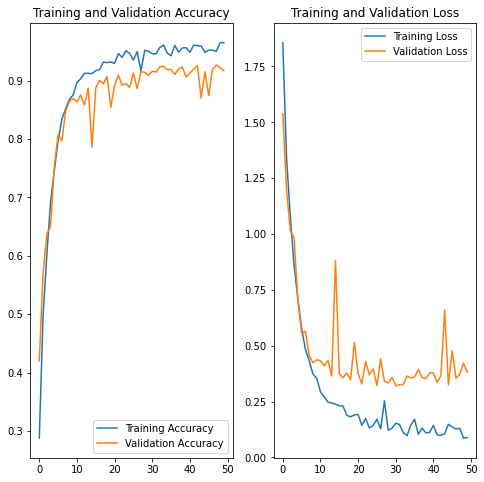

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



The overfitting is greatly reduced with the architecture change and data augmentation strategy. 

We now have a train loss of 0.08 and val loss of 0.38. The train accuracy is 0.96 and the val accuracy is 0.91. 

The model can be further tuned to reduce the overfitting in loss even more. BUt for now this is the best model among the 3 tuned.